# Case Study : eICU Dataset¶

## Background

The eICU Collaborative Research Database is a multi-center database comprising deidentified health data associated with over 200,000 admissions to ICUs across the United States between 2014-2015. The database includes vital sign measurements, care plan documentation, severity of illness measures, diagnosis information, and treatment information. Data is collected through the Philips eICU program, a critical care telehealth program that delivers information to caregivers at the bedside. 

## Objectives

## Feature Selection

Based on the exploratory analysis and the review of related ML tasks, I decided to implement feature selection to enhance model performance. Two feature selection methods were considered:

- **Boruta:** An all-relevant feature selection method using random forest classifier to identify important features.
- **Linear Discriminant Analysis (LDA):** A method used to find the linear combination of features that best separate different classes.


## ML Tasks on Similar Datasets

I researched existing ML tasks performed on similar datasets to establish a baseline understanding of common methodologies. This review provided insights into the types of models typically applied to eICU data, such as:

- **Classification tasks** for predicting patient outcomes.


## Implementation

### Import necessary libraries

In [222]:
!pip install boruta

In [8]:
! pip install -U imbalanced-learn


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc, confusion_matrix
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

### Read data

In [225]:
df_cleaned_drop = pd.read_csv("df_cleaned_drop_ID.csv", index_col=0)

df_cleaned_drop.head()

,AGE,GENDER,ETHNICITY,UNITDISCHARGESTATUS,ALBUMIN_0.0,BICARBONATE_0.0,BUN_0.0,CHLORIDE_0.0,CREATININE_0.0,GLUCOSE_0.0,...,VITAL_TEMPERATURE_14.0,VITAL_TEMPERATURE_15.0,VITAL_TEMPERATURE_16.0,VITAL_TEMPERATURE_17.0,VITAL_TEMPERATURE_18.0,VITAL_TEMPERATURE_19.0,VITAL_TEMPERATURE_20.0,VITAL_TEMPERATURE_21.0,VITAL_TEMPERATURE_22.0,VITAL_TEMPERATURE_23.0
0,81,Female,Caucasian,Alive,3.024564,1.08,23.825029,131.0,30.0,10.5,...,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2
2,80,Female,Caucasian,Alive,3.024564,1.58,24.500000,94.0,37.9,13.2,...,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2
3,48,Male,Caucasian,Alive,4.100000,1.31,28.000000,105.0,48.9,16.6,...,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2
4,65,Male,Caucasian,Alive,4.400000,1.11,28.000000,119.0,39.1,12.6,...,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2
5,30,Male,Caucasian,Alive,3.024564,1.03,26.000000,118.5,38.0,12.4,...,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2


In [226]:
df_cleaned_drop["GENDER"].value_counts()

GENDER
Male      15869
Female    13107
Name: count, dtype: int64

In [227]:
df_cleaned_drop["ETHNICITY"].value_counts()

ETHNICITY
Caucasian    22330
American      3485
Others        3161
Name: count, dtype: int64

In [228]:
df_cleaned_drop.info()

print(f"The data has {df_cleaned_drop.shape[0]} rows and {df_cleaned_drop.shape[1]} columns")

<class 'pandas.core.frame.DataFrame'>
Index: 28976 entries, 0 to 38562
Columns: 187 entries, AGE to VITAL_TEMPERATURE_23.0
dtypes: float64(183), int64(1), object(3)
memory usage: 41.6+ MB
The data has 28976 rows and 187 columns


In [229]:
df_cleaned_drop.describe()

,AGE,ALBUMIN_0.0,BICARBONATE_0.0,BUN_0.0,CHLORIDE_0.0,CREATININE_0.0,GLUCOSE_0.0,HEMATOCRIT_0.0,HEMOGLOBIN_0.0,LACTATE_0.0,...,VITAL_TEMPERATURE_14.0,VITAL_TEMPERATURE_15.0,VITAL_TEMPERATURE_16.0,VITAL_TEMPERATURE_17.0,VITAL_TEMPERATURE_18.0,VITAL_TEMPERATURE_19.0,VITAL_TEMPERATURE_20.0,VITAL_TEMPERATURE_21.0,VITAL_TEMPERATURE_22.0,VITAL_TEMPERATURE_23.0
count,28976.000000,28976.000000,28976.000000,28976.000000,28976.000000,28976.000000,28976.000000,28976.000000,28976.000000,28976.000000,...,28976.000000,28976.000000,28976.000000,28976.000000,28976.000000,28976.000000,28976.000000,28976.000000,28976.000000,28976.000000
mean,64.988887,3.087902,1.643289,24.041091,156.395776,34.890204,11.506499,214.690520,2.204172,102.892519,...,37.335836,37.333370,37.337079,37.335004,37.338671,37.336688,37.336793,37.335875,37.333438,37.333476
std,16.119618,0.604933,1.775991,5.157393,85.858461,7.129924,2.421195,100.679741,1.604551,6.914281,...,3.397145,3.371602,3.385338,3.369652,3.384437,3.359439,3.354130,3.356447,3.314532,3.311523
min,11.000000,0.600000,0.100000,3.000000,11.000000,7.400000,2.500000,0.000000,0.000000,58.000000,...,19.400000,14.550000,17.200000,19.600000,13.700000,24.400000,19.800000,11.100000,20.400000,23.350000
25%,55.000000,2.800000,0.820000,21.500000,111.500000,30.000000,9.800000,153.000000,1.800000,99.000000,...,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000
50%,67.000000,3.024564,1.080000,23.825029,131.000000,34.500000,11.300000,196.000000,1.800000,104.000000,...,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000
75%,77.000000,3.400000,1.680000,26.500000,170.500000,39.800000,13.200000,260.000000,2.000000,107.000000,...,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000,37.200000
max,90.000000,5.700000,40.380000,63.000000,1724.000000,68.000000,23.300000,2032.500000,25.200000,151.000000,...,103.600000,102.700000,102.600000,104.800000,106.050000,104.000000,102.850000,102.200000,102.200000,102.000000


In [230]:
# check missing values

missing_count = df_cleaned_drop.isnull().sum()

missing_count

AGE                       0
GENDER                    0
ETHNICITY                 0
UNITDISCHARGESTATUS       0
ALBUMIN_0.0               0
                         ..
VITAL_TEMPERATURE_19.0    0
VITAL_TEMPERATURE_20.0    0
VITAL_TEMPERATURE_21.0    0
VITAL_TEMPERATURE_22.0    0
VITAL_TEMPERATURE_23.0    0
Length: 187, dtype: int64

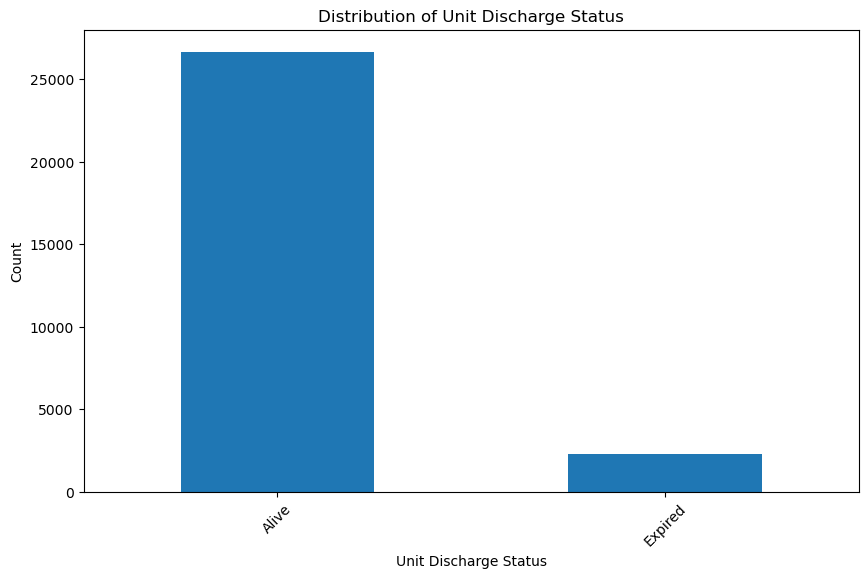

In [231]:
# Target Variable

unit_discharge_status_counts = df_cleaned_drop['UNITDISCHARGESTATUS'].value_counts(dropna=True)

# Plot the bar chart
plt.figure(figsize=(10, 6))
unit_discharge_status_counts.plot(kind='bar')
plt.xlabel('Unit Discharge Status')
plt.ylabel('Count')
plt.title('Distribution of Unit Discharge Status')
plt.xticks(rotation=45)
plt.show()

In [232]:
# Unbalance data
unit_discharge_status_counts

UNITDISCHARGESTATUS
Alive      26677
Expired     2299
Name: count, dtype: int64

# 1. Building a Logistic Regression model

Let's start by splitting our data into a training set.

## Train Test Split

In [234]:
# Preprocess target column

# replace 'Alive' with 1 and 'Expired' with 0
df_cleaned_drop['UNITDISCHARGESTATUS'] = df_cleaned_drop['UNITDISCHARGESTATUS'].replace({'Alive': 1, 'Expired': 0})

# replace 'Male' with 0 and 'Female' with 1
df_cleaned_drop['GENDER'] = df_cleaned_drop['GENDER'].replace({'Male': 0, 'Female': 1})

# replace() method is used to replace values in the selected column: 'Caucasian' is replaced with 0, 'American' is replaced with 1., 'Others' is replaced with 2.

df_cleaned_drop['ETHNICITY'] = df_cleaned_drop['ETHNICITY'].replace({
    'Caucasian': 0,
    'American': 1,
    'Others': 2
})

C:\Users\Duy_Le\AppData\Local\Temp\ipykernel_14352\1724799580.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned_drop['UNITDISCHARGESTATUS'] = df_cleaned_drop['UNITDISCHARGESTATUS'].replace({'Alive': 1, 'Expired': 0})
C:\Users\Duy_Le\AppData\Local\Temp\ipykernel_14352\1724799580.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned_drop['GENDER'] = df_cleaned_drop['GENDER'].replace({'Male': 0, 'Female': 1})
C:\Users\Duy_Le\AppData\Local\Temp\ipykernel_14352\1724799580.py:11: FutureWarning: Downcasting behavior

In [235]:
df_cleaned_drop.head()

,AGE,GENDER,ETHNICITY,UNITDISCHARGESTATUS,ALBUMIN_0.0,BICARBONATE_0.0,BUN_0.0,CHLORIDE_0.0,CREATININE_0.0,GLUCOSE_0.0,...,VITAL_TEMPERATURE_14.0,VITAL_TEMPERATURE_15.0,VITAL_TEMPERATURE_16.0,VITAL_TEMPERATURE_17.0,VITAL_TEMPERATURE_18.0,VITAL_TEMPERATURE_19.0,VITAL_TEMPERATURE_20.0,VITAL_TEMPERATURE_21.0,VITAL_TEMPERATURE_22.0,VITAL_TEMPERATURE_23.0
0,81,1,0,1,3.024564,1.08,23.825029,131.0,30.0,10.5,...,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2
2,80,1,0,1,3.024564,1.58,24.500000,94.0,37.9,13.2,...,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2
3,48,0,0,1,4.100000,1.31,28.000000,105.0,48.9,16.6,...,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2
4,65,0,0,1,4.400000,1.11,28.000000,119.0,39.1,12.6,...,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2
5,30,0,0,1,3.024564,1.03,26.000000,118.5,38.0,12.4,...,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2,37.2


In [236]:
# Identify features and target
X = df_cleaned_drop.drop(columns=['UNITDISCHARGESTATUS'])
y = df_cleaned_drop['UNITDISCHARGESTATUS']

In [237]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing steps
categorical_features = ['gender', 'ethnicity']
numerical_features = [col for col in X.columns if col not in categorical_features]

In [238]:
numerical_features = X.columns  # Assuming all columns except 'UNITDISCHARGESTATUS'

# Scale numerical variables

numerical_transformer = StandardScaler()

# Create preprocessing pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', numerical_transformer)
])

# Preprocessing of training data and fit the pipeline
X_train_scaled = pipeline.fit_transform(X_train)

# Preprocessing of test data
X_test_scaled = pipeline.transform(X_test)

In [239]:
y_test

27366    1
1024     1
27300    1
15483    1
27871    1
        ..
28517    1
31863    1
7345     1
17120    1
13734    1
Name: UNITDISCHARGESTATUS, Length: 5796, dtype: int64

## Training and Predicting

In [329]:
logmodel = LogisticRegression(random_state=42)

# Train the model on the training data
logmodel.fit(X_train, y_train)


C:\Users\Duy_Le\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [331]:
# Predict on the test data
predictions = logmodel.predict(X_test)

## Evaluation

We can check precision,recall,f1-score using classification report!

              precision    recall  f1-score   support

           0       0.43      0.02      0.04       492
           1       0.92      1.00      0.96      5304

    accuracy                           0.91      5796
   macro avg       0.67      0.51      0.50      5796
weighted avg       0.87      0.91      0.88      5796



<Axes: xlabel='Predicted', ylabel='Actual'>

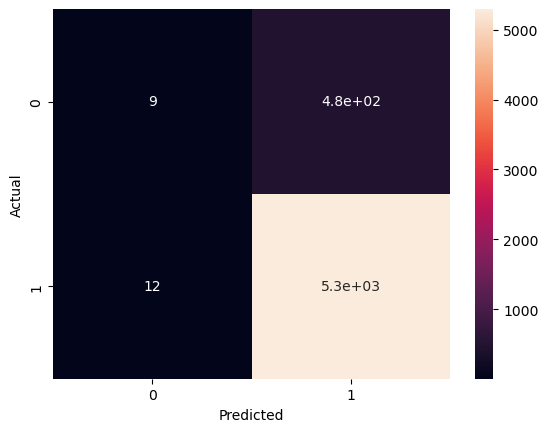

In [334]:
print(classification_report(y_test,predictions))
    
# Generate classification report
report = classification_report(y_test, predictions, output_dict=True)


confusion_matrix(y_test,predictions)

conf_matrix = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True)

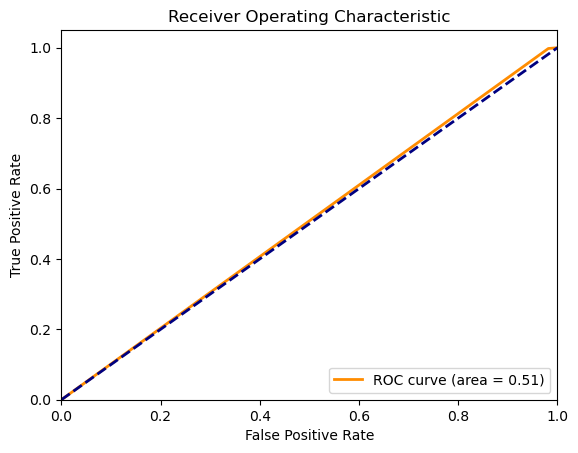

In [336]:
# Binary classification
auc_score = roc_auc_score(y_test,predictions)
    
fpr, tpr, _ = roc_curve(y_test,predictions)
roc_auc = auc(fpr, tpr)
    
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 2. Building a Logistic Regression model with Boruta - Feature selection

In [247]:
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

## Perform Boruta Feature Selection

In [249]:
# Initialize Boruta feature selector with RandomForestClassifier as the estimator
boruta_selector = BorutaPy(estimator=RandomForestClassifier(n_estimators=100, max_depth=5), n_estimators='auto', verbose=2, random_state=42)

# Fit Boruta feature selector on training data
boruta_selector.fit(X_train_scaled, y_train)

# Check selected features
selected_features = np.array(X.columns)[boruta_selector.support_]

print("Selected Features:")
print(selected_features)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	186
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	186
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	186
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	186
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	186
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	186
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	186
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	112
Tentative: 	55
Rejected: 	19
Iteration: 	9 / 100
Confirmed: 	112
Tentative: 	55
Rejected: 	19
Iteration: 	10 / 100
Confirmed: 	112
Tentative: 	55
Rejected: 	19
Iteration: 	11 / 100
Confirmed: 	112
Tentative: 	55
Rejected: 	19
Iteration: 	12 / 100
Confirmed: 	115
Tentative: 	52
Rejected: 	19
Iteration: 	13 / 100
Confirmed: 	115
Tentative: 	45
Rejected: 	26
Iteration: 	14 / 100
Confirmed: 	115
Tentative: 	45
Rejected: 	26
Iteration: 	15 / 100
Confirmed: 	115
Tentative: 	45
Rejected: 	26
Iteration: 	16 / 100
Confirmed: 	

#### Review the features

In [251]:
# Number of features selected in total
num_selected_features = np.sum(boruta_selector.support_)
print(f"Number of selected features: {num_selected_features}")

# Get the selected features
selected_features = np.array(X.columns)[boruta_selector.support_]

# Print the top 10 selected features
print("\nTop 10 selected features:")
for feature in selected_features[:10]:
    print(feature)

Number of selected features: 122

Top 10 selected features:
ALBUMIN_0.0
BUN_0.0
CHLORIDE_0.0
HEMOGLOBIN_0.0
POTASSIUM_0.0
PTT_0.0
VITAL_HEARTRATE_4.0
VITAL_HEARTRATE_18.0
VITAL_HEARTRATE_20.0
VITAL_RESPIRATION_0.0


## Train Logistic Regression Model with Selected Features

In [253]:
# Manually transform the training and test data using the selected features
selected_features = boruta_selector.support_

X_train_selected = X_train_scaled[:, selected_features]
X_test_selected = X_test_scaled[:, selected_features]

# Verify the shape of the transformed data
print(f"Original number of features: {X_train_scaled.shape[1]}")
print(f"Number of features after Boruta selection (training): {X_train_selected.shape[1]}")
print(f"Number of features after Boruta selection (test): {X_test_selected.shape[1]}")

Original number of features: 186
Number of features after Boruta selection (training): 122
Number of features after Boruta selection (test): 122


In [254]:
# Initialize Logistic Regression model
logmode_boruta = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the training data with selected features
logmode_boruta.fit(X_train_selected, y_train)

# Predict on the test data with selected features
predictions1 = logmode_boruta.predict(X_test_selected)


## Evaluation

              precision    recall  f1-score   support

           0       0.42      0.06      0.11       492
           1       0.92      0.99      0.95      5304

    accuracy                           0.91      5796
   macro avg       0.67      0.53      0.53      5796
weighted avg       0.88      0.91      0.88      5796



<Axes: xlabel='Predicted', ylabel='Actual'>

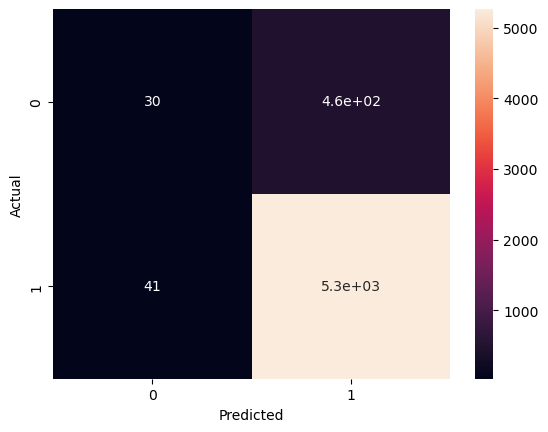

In [256]:
print(classification_report(y_test,predictions1))
    
# Generate classification report
report = classification_report(y_test, predictions1, output_dict=True)


confusion_matrix(y_test,predictions1)

conf_matrix = pd.crosstab(y_test, predictions1, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True)

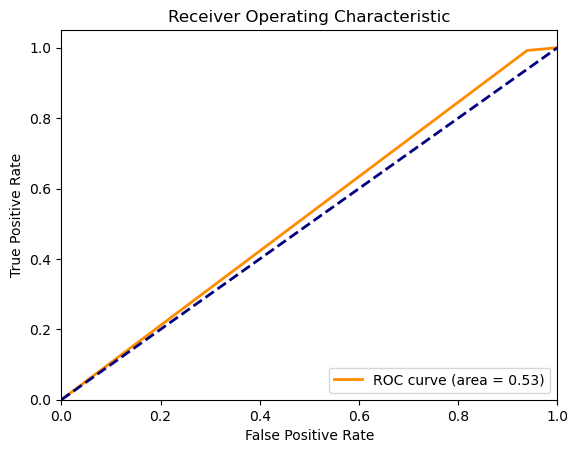

In [344]:
# Binary classification

auc_score = roc_auc_score(y_test, predictions1)
    
fpr, tpr, _ = roc_curve(y_test, predictions1)
roc_auc = auc(fpr, tpr)
    
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 3. Building a Logistic Regression model with Linear Discriminant Analysis (LDA) -  dimensionality reduction

## Apply LDA

In [260]:
# Initialize LDA
lda = LDA()

# Fit LDA on scaled training data
X_train_lda = lda.fit_transform(X_train_scaled, y_train)

# Number of dimensions selected
num_dimensions = lda.explained_variance_ratio_.shape[0]
print(f"Number of dimensions selected by LDA: {num_dimensions}")

Number of dimensions selected by LDA: 1


#### Visualization of Reduced-Dimensional Data

In [262]:
# Number of dimensions selected
num_dimensions = lda.explained_variance_ratio_.shape[0]
print(f"Number of dimensions selected by LDA: {num_dimensions}")

Number of dimensions selected by LDA: 1


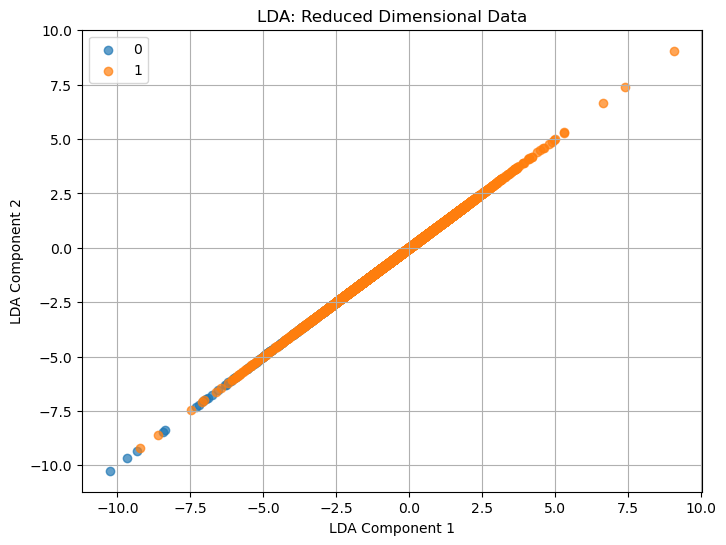

In [263]:
# Visualize reduced-dimensional data (assuming 2 dimensions for simplicity)
plt.figure(figsize=(8, 6))
for label in np.unique(y_train):
    plt.scatter(X_train_lda[y_train == label, 0], X_train_lda[y_train == label, 0], label=label, alpha=0.7)
plt.title('LDA: Reduced Dimensional Data')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend()
plt.grid(True)
plt.show()

#### Preprocessing

In [265]:
# Scale numerical variables if needed
numerical_transformer = StandardScaler()

# Create preprocessing pipeline with LDA
pipeline = Pipeline(steps=[
    ('preprocessor', numerical_transformer),
    ('lda', LDA())  # LDA without specifying n_components initially
])


#### Grid Search for Optimal Components

In [267]:
# Define parameter grid for LDA's n_components
param_grid = {
    'lda__n_components': [1, 2, 3, 4, 5]  # Adjust the range as per your dataset and requirements
}

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit GridSearchCV on training data
grid_search.fit(X_train_scaled, y_train)

# Best parameter and its corresponding score
print(f"Best number of components: {grid_search.best_params_['lda__n_components']}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\Duy_Le\Anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Duy_Le\Anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Duy_Le\Anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Duy_Le\Anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator

Best number of components: 1
Best cross-validation accuracy: 0.92


## Train model with best number of components

In [269]:
# Get the best estimator from GridSearchCV
best_pipeline = grid_search.best_estimator_

# Fit the best pipeline on the entire training set (using scaled data)
best_pipeline.fit(X_train_scaled, y_train)

# Predict on the test set
predictions2 = best_pipeline.predict(X_test_scaled)


In [270]:
## Evaluate the final model

              precision    recall  f1-score   support

           0       0.27      0.07      0.11       492
           1       0.92      0.98      0.95      5304

    accuracy                           0.90      5796
   macro avg       0.60      0.53      0.53      5796
weighted avg       0.86      0.90      0.88      5796



<Axes: xlabel='Predicted', ylabel='Actual'>

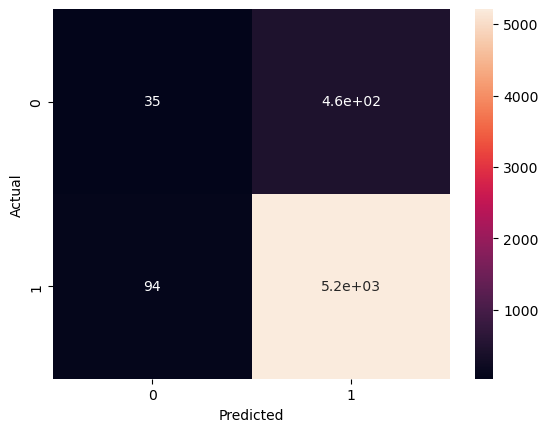

In [271]:
print(classification_report(y_test,predictions2))
    
# Generate classification report
report = classification_report(y_test, predictions2, output_dict=True)


confusion_matrix(y_test,predictions2)

conf_matrix = pd.crosstab(y_test, predictions2, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True)

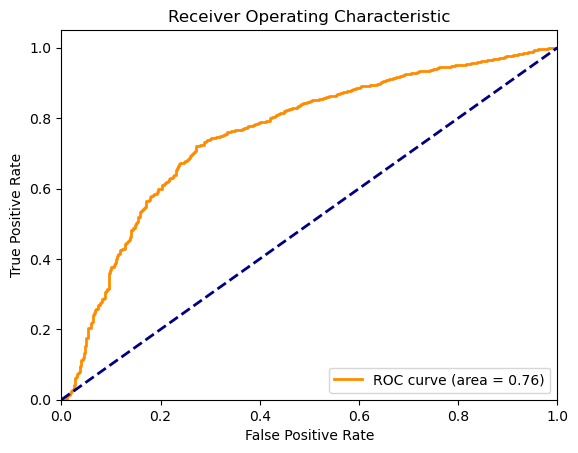

In [338]:
y_test_bin = y_test
y_pred_prob = best_pipeline.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test_bin, y_pred_prob)
    
fpr, tpr, _ = roc_curve(y_test_bin, y_pred_prob)
roc_auc = auc(fpr, tpr)
    
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 4. Comparasion 

In [6]:
data = {
    'Model': ['Logistic Regression', 'Logistic Regression with Boruta', 'Logistic Regression with LDA'],
    'Precision (0)': [0.43, 0.42, 0.27],
    'Recall (0)': [0.02, 0.06, 0.07],
    'F1-score (0)': [0.04, 0.11, 0.11],
    'Support (0)': [492, 492, 492],
    'Precision (1)': [0.92, 0.92, 0.92],
    'Recall (1)': [1.00, 0.99, 0.98],
    'F1-score (1)': [0.96, 0.95, 0.95],
    'Support (1)': [5304, 5304, 5304],
    'Accuracy': [0.91, 0.91, 0.90]
} 

# Create DataFrames
df_logreg = pd.DataFrame(data)

# Set Model as index for better readability
df_logreg.set_index('Model', inplace=True)

# Display the combined DataFrame
print("Combined Evaluation Metrics for Logistic Regression Models:")
df_logreg

Combined Evaluation Metrics for Logistic Regression Models:


,Precision (0),Recall (0),F1-score (0),Support (0),Precision (1),Recall (1),F1-score (1),Support (1),Accuracy
Model,,,,,,,,,
Logistic Regression,0.43,0.02,0.04,492,0.92,1.00,0.96,5304,0.91
Logistic Regression with Boruta,0.42,0.06,0.11,492,0.92,0.99,0.95,5304,0.91
Logistic Regression with LDA,0.27,0.07,0.11,492,0.92,0.98,0.95,5304,0.90


- Logistic Regression: A standard logistic regression model using all 186 features.

- Logistic Regression with Boruta: A logistic regression model where features were selected using the Boruta algorithm, resulting in a model with 122 features.

- Logistic Regression with LDA: A logistic regression model where features were reduced using Linear Discriminant Analysis (LDA) to only one component.

Analysis:

All models have excellent performance on the majority class (1). This is evident from the high precision, recall, F1-score, and support for class 1. However, their performance on the minority class (0) is significantly lower.
Boruta feature selection slightly improves the F1-score for the minority class. While the precision and recall for class 0 remain low, the F1-score increases from 0.04 to 0.11, suggesting a slight improvement in the model's ability to predict the minority class.

LDA feature reduction leads to a significant decrease in the precision for the minority class. While it maintains a similar F1-score to Boruta, the lower precision indicates it is less effective at correctly identifying minority class cases.
Best Model:

I prioritize the recall metric in this case, so the Logistic Regression with LDA model emerges as the best choice.
    
- High recall means identifying more patients at risk of death, even if some are ultimately fine. This allows for close monitoring and proactive care, potentially saving lives.

- Low recall means missing patients who might be critically ill. This could lead to delayed interventions and potentially worse outcomes.

#### Logistic Regression with LDA model is the best model:

- Higher recall
- Run faster (1 minute), save computational resources >> Logistic Regression with Boruta takes a lot of time (30 minutes)

# 5. Improve the best model - Using BalancedBaggingClassifier with Near Miss Under-Sampling

A technique to improve the imbalanced dataset -  : 99%% alive and 1 % deadlth in the target variable. 

In [356]:
# Train the balanced bagging classifier model using near miss under sampling
bbc_nm = BalancedBaggingClassifier(random_state=42, sampler=(NearMiss(version=3)))
bbc_nm_model_cv = cross_validate(bbc_nm, X_train_scaled, y_train, cv = 5, n_jobs = -1, scoring="recall")

# Check the model performance
print(f"{bbc_nm_model_cv['test_score'].mean():.3f} +/- {bbc_nm_model_cv['test_score'].std():.3f}")

0.982 +/- 0.001


In [360]:
# Initialize Balanced Bagging Classifier with Near Miss version 3 as sampler
bbc_nm = BalancedBaggingClassifier(estimator=best_pipeline, sampler=NearMiss(version=3), random_state=42)

# Fit the Balanced Bagging Classifier with cross-validation
bbc_nm_model_cv = cross_validate(bbc_nm, X_train_scaled, y_train, cv=5, n_jobs=-1, scoring="recall")


# Check the model performance
print(f"Mean Recall: {bbc_nm_model_cv['test_score'].mean():.3f} +/- {bbc_nm_model_cv['test_score'].std():.3f}")

Mean Recall: 0.720 +/- 0.008


In [364]:
# Predict on the test set
bbc_nm.fit(X_train_scaled, y_train)
predictions3 = bbc_nm.predict(X_test_scaled)

              precision    recall  f1-score   support

           0       0.15      0.56      0.24       492
           1       0.95      0.71      0.81      5304

    accuracy                           0.70      5796
   macro avg       0.55      0.63      0.52      5796
weighted avg       0.88      0.70      0.76      5796



<Axes: xlabel='Predicted', ylabel='Actual'>

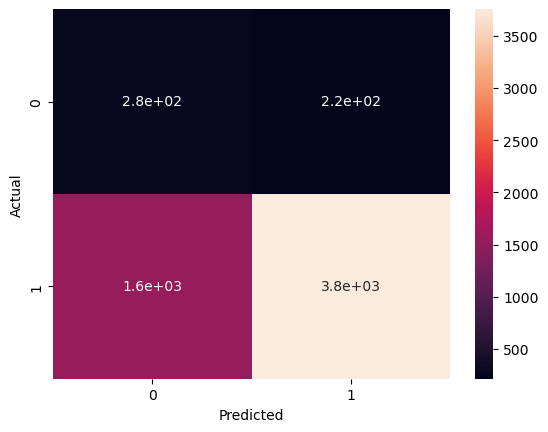

In [366]:
print(classification_report(y_test,predictions3))
    
# Generate classification report
report = classification_report(y_test, predictions3, output_dict=True)


confusion_matrix(y_test,predictions3)

conf_matrix = pd.crosstab(y_test, predictions3, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True)

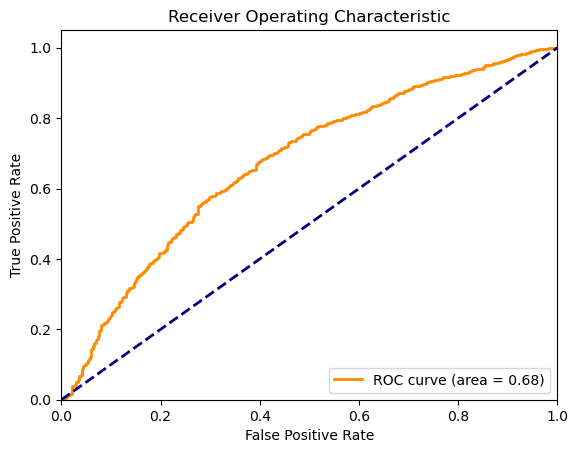

In [368]:
y_test_bin = y_test
y_pred_prob = bbc_nm.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test_bin, y_pred_prob)
    
fpr, tpr, _ = roc_curve(y_test_bin, y_pred_prob)
roc_auc = auc(fpr, tpr)
    
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

By applying BalancedBaggingClassifier with Near Miss Under-Sampling for imbalanced classification, The recall for predicting "death" has improved from 0.07 to 0.56.